In [14]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import time

key = random.PRNGKey(0)

In [6]:
d = {"one": 1, "two": 2}
# for k in d:
#     d[k] = 0
d.get("one", 0)

1

# Diagonals


In [15]:
x = np.array([[1,2,3], [4,5,6], [7,8,9]])

In [16]:
x

DeviceArray([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]], dtype=int32)

In [24]:
x.diagonal(axis1=0, axis2=1)

DeviceArray([1, 5, 9], dtype=int32)

In [ ]:
x.diagonal

# Jacfwd and Jacrev

In [10]:
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(np.dot(inputs, W) + b)

# Build a toy dataset.
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [13]:
from jax import jacfwd

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs) # IN shape (3,); OUT shape (4,)


print("IN shape:", W.shape)
print("OUT shape:", f(W).shape)
print()

J = jacfwd(f)(W)
print("jacfwd result, with shape", J.shape)
print(J)

IN shape: (3,)
OUT shape: (4,)

jacfwd result, with shape (4, 3)
[[ 0.10874645  0.23422311  0.16102839]
 [ 0.08166754 -0.10022834  0.0139206 ]
 [ 0.08774894  0.01012488 -0.21937235]
 [ 0.04643591 -0.15625057  0.08722422]]


This means the `jacfwd` result is an array of shape `(out_shape, in_shape)`.

# 3d plotting and unsorted data

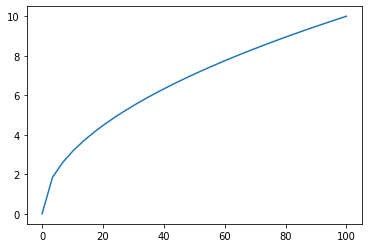

In [3]:
grid = np.linspace(0, 100, 30)
data = np.sqrt(grid)
plt.plot(grid, data)

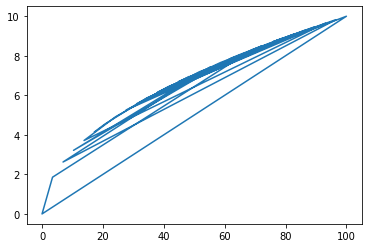

In [12]:
grid = random.shuffle(key, grid)
data = np.sqrt(grid)
_ = plt.plot(grid, data)

# concat and mean of dictionaries

In [2]:
from utils import dict_concatenate, dict_mean

In [14]:
random.split(key)

DeviceArray([[2384771982, 3928867769],
             [1278412471, 2182328957]], dtype=uint32)

In [25]:
keys = [random.PRNGKey(seed) for seed in range(3)]

dicts = [{"one": random.normal(key, shape=(10, 5))} for key in keys]

In [26]:
dict_concatenate(dicts)["one"].shape

(3, 10, 5)

In [27]:
dict_mean(dicts)["one"].shape

(10, 5)

# why does runtime of `jit`ted function vary over orders of magnitude?

First TODO: find a simple example of issue.

In [2]:
from svgd import update
jupdate = jit(update, static_argnums=(1,)) # logp is static. When logp changes, jit recompiles.

In [3]:
# data and functions
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

print('logp is located at', hex(id(logp)))

n = 100
d=1
stepsize = 0.01

# L = int(1 / stepsize)
L = 10**3
# L = 1

# generate data
key = random.PRNGKey(7)
x0 = random.normal(key, (n,d)) - 10

h = 4
print('h is located at', hex(id(h))) # memory location

logp is located at 0x7f57a4ae4d08


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


h is located at 0xa68b20


In [4]:
def svgd(x, stepsize, bandwidth, logp, L):
    assert x.ndim == 2

    d = x.shape[1]
    log = {
        "particle_mean": np.empty(shape=(L, d)),
        "particle_var": np.empty(shape=(L, d))
    }

    def update_fun(i, u):
        """
        1) compute updated x,
        2) log mean and var

        Parameters:
        * i: iteration counter (unused)
        * u = [x, log]

        Returns:
        [updated_x, log]
        """
        x, log = u
        x = update(x, logp, stepsize, bandwidth)

        update_dict = {
            "particle_mean": np.mean(x, axis=0),
            "particle_var": np.var(x, axis=0)
        }

        for key in log.keys():
            log[key] = index_update(log[key], index[i, :], update_dict[key])

        return [x, log]

    xout, log = lax.fori_loop(0, L, update_fun, [x, log])
    return xout, log

svgd = jit(svgd, static_argnums=(3,4))

In [5]:
m = 100
times = []
for _ in range(m):
    st = time.time()
    xout, log = svgd(x0, stepsize, h, logp, L)
    end = time.time()
    times.append(end-st)

In [6]:
print(np.mean(np.array(times)))
print()
# print(times)

1.1749398



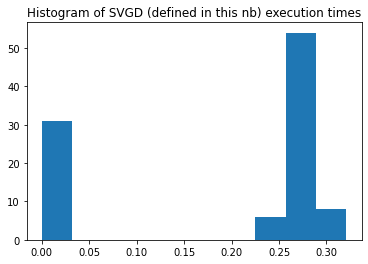

In [21]:
_ = plt.hist(times[1:])
_ = plt.title("Histogram of SVGD (defined in this nb) execution times")

### compare:

In [8]:
from svgd import SVGD
csvgd = SVGD()

In [27]:
m = 100
ctimes = []
for _ in range(m):
    skey, _ = random.split(key)
    x0 = random.normal(skey, (n,d)) - 10
    
    st = time.time()
    xout, log = csvgd.fixed_param_svgd(x0, logp, stepsize, L, h)
    end = time.time()
    
    ctimes.append(end-st)

In [28]:
# _ = plt.hist(ctimes[1:])
# _ = plt.title("Histogram of SVGD (defined in svgd.py) execution times")

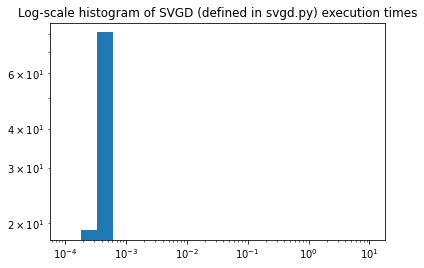

In [29]:
bins = np.logspace(-4, 1, num=20)
plt.hist(ctimes, bins = bins)
plt.xscale('log')
plt.yscale('log')
_ = plt.title("Log-scale histogram of SVGD (defined in svgd.py) execution times")

Note: this means that sometimes, svgd is 1000x faster than at other times!??

### attempt reduction:

In [ ]:
@jit
def jfun(x, y):
    """x and y are 2-dim arrays"""
    return np.matmul(x, y)

X = random.normal(key, (100,100))
key, _ = random.split(key)
Y = random.normal(key, (100,100))

jfun(x, y).shape

@jit
def jloop(x):
    return lax.fori_loop(0, 100, lambda i, x: np.matmul(x, Y), init_val=x)

In [ ]:
jloop(X).shape

In [ ]:
m = 1000
times = []
for _ in range(m):
    st = time.time()
    jloop(X).shape
    end = time.time()
    times.append(end-st)

In [ ]:
plt.hist(times)

In [ ]:
m = 1000
times = []
for _ in range(m):
    st = time.time()
    jfun(X, Y).shape
    end = time.time()
    times.append(end-st)

In [ ]:
_ = plt.hist(times)

# understanding classes and `self`

In [ ]:
class Test():
    def __init__(self):
        pass
    
    t = 2
    
    def unj_method(self, x):
        def subfun(y):
            return y**self.t
        return subfun(x)
    
    method = jit(unj_method, static_argnums=(0,))
    

In [ ]:
test = Test()
test.method(2)

# compare times for jitted svgd: fixed param vs not fixed

In [ ]:
from svgd import svgd, fixed_param_svgd

In [ ]:
from jax.scipy.stats import norm
from svgd import kernel_param_update_rule

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

n = 10
stepsize = 0.01
L = int(1 / stepsize)

# generate data
key = random.PRNGKey(1)
x = random.normal(key, (n,1)) - 10

kernel_param = kernel_param_update_rule(x)
hfun = lambda x: kernel_param

First just once

In [ ]:
%timeit svgd(x, logp, stepsize, L, hfun).block_until_ready()

In [ ]:
%timeit fixed_param_svgd(x, logp, stepsize, L, kernel_param).block_until_ready()

And now see what happens if we sweep over a grid of `kernel_param` values. First, define param search using regular svgd:

In [ ]:
def get_mse(logp, n, stepsize, L, m, q, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * m: integer, number of samples for averaging MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0
    * kernel_param_update_rule: callable, takes the updated particles as input and outputs an updated set of kernel parameters.
    If kernel_param constant, set to lambda x: const

    OUT:
    * dictionary of MSE values

    """
    mse1 = []
    mse2 = []
    mse3 = []
    for seed in range(0, m):
        key = random.PRNGKey(seed)
        x = q(key, n)

        xout = svgd(x, logp, stepsize, L, kernel_param_update_rule)
        mse1.append((np.mean(xout) - 2/3)**2)
        mse2.append((np.mean(xout**2) - 5)**2)

        w = random.normal(key, (1,))
        mse3.append((np.mean(np.cos(w * xout) - np.exp(-w**2 / 2))**2))

    mse1 = np.mean(np.array(mse1))
    mse2 = np.mean(np.array(mse2))
    mse3 = np.mean(np.array(mse3))

    mse = {
    "E[x]": mse1,
    "E[x^2]": mse2,
    "E[cos(wx)]": mse3
    }
    
    return mse

default_q = lambda key, n: random.normal(key, shape=(n,1)) - 10
def kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * kernel_param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for h in kernel_param_grid:
        mse1, mse2, mse3 = list(get_mse(logp, n, stepsize, L, m, q, lambda x: h).values())
        
        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
    
    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses

In [ ]:
def get_mse_fixed_param(logp, n, stepsize, L, m, q, kernel_param):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * m: integer, number of samples for averaging MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    OUT:
    * dictionary of MSE values

    """
    mse1 = []
    mse2 = []
    mse3 = []
    for seed in range(0, m):
        key = random.PRNGKey(seed)
        x = q(key, n)

        xout = fixed_param_svgd(x, logp, stepsize, L, kernel_param)
        mse1.append((np.mean(xout) - 2/3)**2)
        mse2.append((np.mean(xout**2) - 5)**2)

        w = random.normal(key, (1,))
        mse3.append((np.mean(np.cos(w * xout) - np.exp(-w**2 / 2))**2))

    mse1 = np.mean(np.array(mse1))
    mse2 = np.mean(np.array(mse2))
    mse3 = np.mean(np.array(mse3))

    mse = {
    "E[x]": mse1,
    "E[x^2]": mse2,
    "E[cos(wx)]": mse3
    }
    
    return mse

default_q = lambda key, n: random.normal(key, shape=(n,1)) - 10
def fixed_kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * kernel_param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for h in kernel_param_grid:
        mse1, mse2, mse3 = list(get_mse_fixed_param(logp, n, stepsize, L, m, q, h).values())
        
        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
    
    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses

Get times:

In [ ]:
n = 10
stepsize = 0.01
L = int(1 / stepsize)
kernel_param_grid = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful
m = 10

q = lambda key, n: random.normal(key, shape=(n,1)) - 10

In [ ]:
start_time = time.time()
mses = kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q)
elapsed_time = time.time() - start_time
print(elapsed_time)

In [ ]:
start_time = time.time()
mses_f = fixed_kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q)
elapsed_time_f = time.time() - start_time
print(elapsed_time_f)

Hypothesis: inefficiency comes from recompiling every time for a new `kernel_param`.

Now the question is: did I just add this inefficiency while `jit`ing `svgd`? Or was it already there? Let's check.

```
def old_svgd(x, logp, stepsize, L, kernel_param_update_rule):
...
```

In [ ]:
from svgd import update
def old_svgd(x, logp, stepsize, L, kernel_param_update_rule):
    """
    IN:
    * x is an np array of shape n x d
    * logp is the log of a differentiable pdf p (callable)
    * stepsize is a float
    * kernel_param is a positive scalar: bandwidth parameter for RBF kernel
    * L is an integer (number of iterations)
    * kernel_param_update_rule is a callable that takes the updated particles as input and outputs an updated set of kernel parameters. If supplied, the argument kernel_param will be ignored.

    OUT:
    * Updated particles x (np array of shape n x d) after L steps of SVGD
    * dictionary with logs
    """
    assert x.ndim == 2

    log = {
        "kernel_param": [],
        "particle_mean": [],
        "particle_var": []
    }

    
    for i in range(L):
        kernel_param = kernel_param_update_rule(x)
        x = update(x, logp, stepsize, kernel_param)

        update_dict = {
            "kernel_param": kernel_param,
            "particle_mean": np.mean(x, axis=0),
            "particle_var": np.var(x, axis=0)
        }

        for key in log.keys():
            log[key].append(update_dict[key])
            
    for key in log.keys():
        log[key] = np.array(log[key])

    return x#, log

In [ ]:
%timeit old_svgd(x, logp, stepsize, L, hfun).block_until_ready()

So seems the old SVGD was around 1000 times slower not counting recompiles. Note that `%timeit` doesn't count recompiling. Let's see what happens if we define an `old_kernel_param_search`:

In [ ]:
def get_mse_old(logp, n, stepsize, L, m, q, kernel_param_fun):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * m: integer, number of samples for averaging MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    OUT:
    * dictionary of MSE values

    """
    mse1 = []
    mse2 = []
    mse3 = []
    for seed in range(0, m):
        key = random.PRNGKey(seed)
        x = q(key, n)

        xout = old_svgd(x, logp, stepsize, L, kernel_param_fun)
        mse1.append((np.mean(xout) - 2/3)**2)
        mse2.append((np.mean(xout**2) - 5)**2)

        w = random.normal(key, (1,))
        mse3.append((np.mean(np.cos(w * xout) - np.exp(-w**2 / 2))**2))

    mse1 = np.mean(np.array(mse1))
    mse2 = np.mean(np.array(mse2))
    mse3 = np.mean(np.array(mse3))

    mse = {
    "E[x]": mse1,
    "E[x^2]": mse2,
    "E[cos(wx)]": mse3
    }
    
    return mse

default_q = lambda key, n: random.normal(key, shape=(n,1)) - 10
def old_kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * kernel_param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for h in kernel_param_grid:
        mse1, mse2, mse3 = list(get_mse_old(logp, n, stepsize, L, m, q, lambda x: h).values())
        
        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
    
    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses

In [ ]:
start_time = time.time()
mses_o = old_kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q)
elapsed_time_o = time.time() - start_time
print(elapsed_time_o)

This is around a third of the svgd version that recompiles at every new kernel param. This is consistent with the above hypothesis, since `old_svgd` here only recompiles every `m` runs when a new kernel param is tried. So hypothesis: `elapsed_time` / `elapsed_time_o` is circa equal to `m`.

In [ ]:
print(m)
print(elapsed_time / elapsed_time_o)

Damn, hypothesis discomfirmed (`m`=10, random seed `PRNGKey(1)`)

# another `fori_loop` test

In [ ]:
def update_fun(i, lis):
    lis.append(i)
    del lis[0]
    return lis

lax.fori_loop(0, 10, update_fun, [1, 2, 3])

In [ ]:
python_fori_loop(0, 10, update_fun, [1,2,3])

### and another one

In [ ]:
def test_variable_n_iter(n_iter):
    return lax.fori_loop(0, n_iter, lambda i, n: n+1, 0)
test_variable_n_iter(10)

In [ ]:
jit(test_variable_n_iter)(15)

Works!

# `lax.scan`

Rough python equivalent:    

In [ ]:
def scan(f, init, xs, length=None):
    if xs is None:
        xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, np.stack(ys)

Can we define `fori_loop` in terms of `scan`? Code taken from a github issue:

In [ ]:
from jax import lax

In [ ]:
def differentiable_fori_loop(lower, upper, body_fun, init_val):
    f = lambda x, i: (body_fun(i, x), ())
    result, _ = lax.scan(f, init_val, np.arange(lower, upper))
    return result

In [ ]:
def python_fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val

test:

In [ ]:
f = lambda i, x: x**2 + i

In [ ]:
lax.fori_loop(0, 3, f, 1)

In [ ]:
python_fori_loop(0, 3, f, 1)

In [ ]:
differentiable_fori_loop(0, 3, f, 1)

# fori loop

In [ ]:
from jax.lax import fori_loop

In [ ]:
a = 1

In [ ]:
@jit
def test(L):
    return fori_loop(0, L, lambda i, n: n+1, 1)

In [ ]:
test(10)

Compare a normal for loop, where we cant `jit` the function:

In [ ]:
# @jit
def test2(L):
    x = 1 # init_val
    for _ in range(L):
        x = x + 1
    return x

In [ ]:
test2(10)

### using `grad` with `fori_loop`

In [ ]:
def test3(x):
    """output x^4 using fori loop to compute"""
    return fori_loop(0, 2, lambda i, y: y*y, x)

In [ ]:
test3(3.)

In [ ]:
grad(test3)(3.)

In [ ]:
from jax import jacfwd
jacfwd(test3)(3.) # 4*x^3 = 4 * 27 = 108

# gpu vs cpu

In [ ]:
from jax.lib import xla_bridge
backend = xla_bridge.get_backend().platform
print(xla_bridge.get_backend().platform)

In [ ]:
key = random.PRNGKey(0)
d = 10000
x = random.normal(key, shape=(d, d))
key = random.split(key, 1)[0]
y = random.normal(key, shape=(d, d))

In [ ]:
print(f"Running on {backend}.")
print()
%timeit np.matmul(x, y).block_until_ready()

## `np.sort`

In [ ]:
x = np.array([[2,3,4],
              [3,2,1]])
print(x.shape)
np.sort(x)

In [ ]:
np.sort(x, axis=0)

In [ ]:
np.sort(x, axis=1)

# can `jit` take care of this?

In [ ]:
batched_vdot = vmap(np.vdot)

In [ ]:
def test(x, y):
    """
    do a lot of useless repetitive stuff. return np.vdot(x, y)
    """
    n = 2 * 10**6
    xtiled = np.tile(x, (n, 1))
    ytiled = np.tile(y, (n, 1))
    out = batched_vdot(xtiled, ytiled)
    return out[0]

jt = jit(test)

In [ ]:
x = np.array([1,1,1])
y = np.array([1,2,3])

In [ ]:
%timeit test(x, y)

%timeit jt(x, y).block_until_ready()

jup, it can

In [ ]:
def quicktest(x, y):
    n = 2
    xtiled = np.tile(x, (n, 1))
    ytiled = np.tile(y, (n, 1))
    out = batched_vdot(xtiled, ytiled)
    return out[0]

qjt = jit(quicktest)

In [ ]:
%timeit quicktest(x, y)

In [ ]:
%timeit qjt(x, y).block_until_ready()

## kernel computation

In [ ]:
from utils import single_rbf, ard
for x in np.linspace(-10, 10, 30):
    x = np.array([x])
    for y in np.linspace(-10, 10, 30):
        y = np.array([y])
        for h in np.linspace(1, 100, 5):
#             print("x = ", x)
#             print("y = ", y)
#             print()
#             print("rbf(x, y): ", single_rbf(x, y, h))
#             print("ard(x, y): ", ard(x, y, h))
#             print()
#             print("-----------")
            assert single_rbf(x, y, h) == ard(x, y, h)

## misc jax:

In [ ]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

In [ ]:
# multiply matrices
size = 3000
x = random.normal(key, (size, size), dtype=np.float32)
%timeit np.dot(x, x.T).block_until_ready()  # runs on the GPU

In [ ]:
import numpy as onp  # original CPU-backed NumPy
x = onp.random.normal(size=(size, size)).astype(onp.float32)
%timeit np.dot(x, x.T).block_until_ready()

In [ ]:
from jax import device_put

x = onp.random.normal(size=(size, size)).astype(onp.float32)
x = device_put(x)
%timeit np.dot(x, x.T).block_until_ready()

Using `jit`

In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * np.where(x > 0, x, alpha * np.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

In [ ]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

take diff


In [ ]:
@jit
def sum_logistic(x):
    return np.sum(1.0 / (1.0 + np.exp(-x)))

x = np.arange(3.)
print(sum_logistic(x))
print(grad(sum_logistic)(x))

In [ ]:
x = random.normal(key, (10, 3))
batched_sum = vmap(sum_logistic)
batched_sum(x)

In [ ]:
def test(x, y):
    return np.sum(x**2 + y**2)

In [ ]:
x, y  = [random.normal(key, (10,3)), random.normal(key + 1, (10,3))]
print('single argument:', test(x[0], y[0]), '\n')
print('batch output shape:', vmap(test)(x, y).shape)
print('batch output:', vmap(test)(x, y))

In [ ]:
np.append(np.array([1,2,3]), 4)

# pytorch distance matrix

In [ ]:
import torch

In [ ]:
x = torch.rand(10, 2)
x

In [ ]:
x.split(1)

In [ ]:
row = x.split(1)[0]
row

In [ ]:
r_v = row.expand_as(x)
r_v

In [ ]:
sq_dist = torch.sum((r_v - x) ** 2, 1)
print(sq_dist.shape)
sq_dist

In [ ]:
sq_dist.view(1, -1).shape

In [ ]:
def row_pairwise_distances(x, y=None, dist_mat=None):
    if y is None:
        y = x
    if dist_mat is None:
        dtype = x.data.type()
        dist_mat = Variable(torch.Tensor(x.size()[0], y.size()[0]).type(dtype))

    for i, row in enumerate(x.split(1)):
        r_v = row.expand_as(y)
        sq_dist = torch.sum((r_v - y) ** 2, 1)
        dist_mat[i] = sq_dist.view(1, -1)
    return dist_mat

# random stuff

## first question
does `jit` cache results if it needs them again? that is, does it skip over repeated computations?

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [ ]:
m = 10**4
def h(x):
    for i in range(m):
        x += i
    return x

In [ ]:
h(2)

In [ ]:
def f1(x):
    """
    computation of h is repeated needlessly
    """
    out = 0
    for i in range(10):
        out += h(x) + i
    return out

In [ ]:
def f2(x):
    """
    h(x) is computed only once
    """
    out = 0
    hx = h(x)
    for i in range(10):
        out += hx + i
    return out

In [ ]:
s = 4

In [ ]:
assert f1(s) == f2(s)

In [ ]:
%timeit f1(s)
%timeit f2(s)
%timeit jit(f1)(s).block_until_ready()
%timeit jit(f2)(s).block_until_ready()

## next question:
does `lax.fori_loop` compile more quickly?

In [ ]:
from jax import lax

In [ ]:
m = 10**4
s = 4

In [ ]:
def h1(x):
    body = lambda i, val: val + i
    for i in range(m):
        x = body(i, x)
    return x

In [ ]:
def h2(x):
    body = lambda i, val: val + i
    return lax.fori_loop(0, m, body, init_val=x)

In [ ]:
jit(h1)(s)

In [ ]:
jit(h2)(s)

yeees, it does!

## Next question:
when we use `lax.fori_loop`, do we get the same speedup for repeated computations?

In [ ]:
assert h(s) == h1(s)

In [ ]:
# now we use the lax fori loop h1
def f1_lax(x):
    """
    computation of h is repeated needlessly
    """
    out = 0
#     for i in range(10):
#         out += h1(x) + i
        
    out = lax.fori_loop(0, 10, lambda i, val: val + h1(x) + i, init_val=out)
    return out

def f2_lax(x):
    """
    h(x) is computed only once
    """
    out = 0
    hx = h1(x)
#     for i in range(10):
#         out += hx + i
        
    out = lax.fori_loop(0, 10, lambda i, val: val + hx + i, init_val=out)
    return out

In [ ]:
assert f1_lax(s) == f1(s)
assert f2_lax(s) == f2(s)
assert f1(s) == f2(s)

In [ ]:
# still compiles fast:
jit(f1_lax)(s)

In [ ]:
%timeit f1_lax(s)
%timeit f2_lax(s)
%timeit jit(f1_lax)(s).block_until_ready()
%timeit jit(f2_lax)(s).block_until_ready()

we do indeed have a speedup.

## How to plot 3D

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [ ]:
# Make data.
X = np.linspace(-5, 5, 50)
Y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(X, Y) # both shape (40, 40)

Z = X**2 + Y**2

# plot
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)